In [9]:
# %pip install salabim
import salabim as sim
import numpy as np

# Preemptive priority

Salabim Components have a `isbumped()` function that returns whether the component was preempted from a resource.  They also
have a method for requesting a resource with a given priority. Preemption can be set as an attribute of the Resource object.

Here we simulate a queue with an infinite buffer and two request classes, one of which has preemptive priority.
Priorities in Salabim are min-first, i.e., a lower value equals higher priority.  Preempted requests return to the **back**
of the queue to seek completion of service.

In [24]:
# parameters
nServers = 10
lambd0 = 3
lambd1 = 6
mu0 = 1
mu1 = 1

env = sim.Environment(trace=False)

env.nArr = [0, 0] # Counters

# Monitors
sys_time = [
    sim.Monitor('sys_time0'),
    sim.Monitor('sys_time1')
]
preemptMonitor = sim.Monitor('number of premptions')

class Generator(sim.Component):

    def setup(self, prio, lambd, mu):
        self.prio = prio
        self.iat = sim.Exponential(rate=lambd)
        self.service = sim.Exponential(rate=mu)

    def process(self):
        while True:
            yield self.hold(self.iat.sample())
            Request(f'Request{self.prio}', prio=self.prio, service_time=self.service.sample())

class Request(sim.Component):

    # The default constructor calls setup(), passing on all
    # keyword arguments other than `name`
    def setup(self, prio, service_time):
        self.prio = prio
        self.service_time = service_time

    def process(self):
        t0 = env.now()
        nPreemptions = 0

        # Count arrivals
        env.nArr[self.prio] += 1
        if (env.nArr[0] + env.nArr[1]) % 2_000 == 0:
            print(env.nArr, sys_time[0].mean(), sys_time[1].mean(), preemptMonitor.mean())
        
        # Seek service in a loop until remaining service time is zero
        remain_time = self.service_time
        while remain_time > 0:
            # Fetch server (initial fetch + after every preemption)
            yield self.request((servers,1,self.prio))

            # Attempt to hold server for the remaining service time.
            # Use `mode_time` to track last start/resumption of service.
            yield self.hold(remain_time, mode='')
            if not self.isbumped():
                break # Service complete
            remain_time -= (env.now() - self.mode_time()) # Service not complete
            nPreemptions += 1
        
        # Statistics
        preemptMonitor.tally(nPreemptions)
        sys_time[self.prio].tally(env.now() - t0) # total time in system including waiting time


servers = sim.Resource('servers', capacity=nServers, preemptive=True)
gen0 = Generator('Generator0', prio=0, lambd=lambd0, mu=mu0)
gen1 = Generator('Generator1', prio=1, lambd=lambd1, mu=mu1)

env.run(till=2000)

[653, 1347] 0.9600208687573751 1.6381594045993424 1.4608826479438315
[1341, 2659] 0.9807218410172979 2.136378361498004 1.5214554579673776
[1982, 4018] 0.9810161964609332 1.9522822663420123 1.4553810160427807
[2638, 5362] 1.012376456538938 1.9308365426019707 1.4494804056591961
[3341, 6659] 1.0019599311692127 2.1631122434549126 1.5063088323653115
[4011, 7989] 0.9967621357924955 2.0696057292835963 1.48803069480357
[4695, 9305] 1.0001953435268587 2.0881677585692713 1.5051170113790882
[5345, 10655] 0.9957006922505842 2.0099585304170686 1.4666374835845164
[5981, 12019] 1.0043403967766897 2.0705515996265453 1.479405543804965


In [25]:
print(sys_time[0].mean(), sys_time[0].std()) # total system time, priority 0
print(sys_time[1].mean(), sys_time[1].std()) # total system time, priority 1
print(preemptMonitor.mean(), preemptMonitor.std()) # mean number of preemptions for priority 1 requests

1.0050849459964906 0.9972770648868267
2.0950243168229172 2.169802371359924
1.4878317365928861 2.679312298603276


The following code plots a histogram of the number of preemptions of each priority-1 request.

[0 0 0 ... 5 3 0]


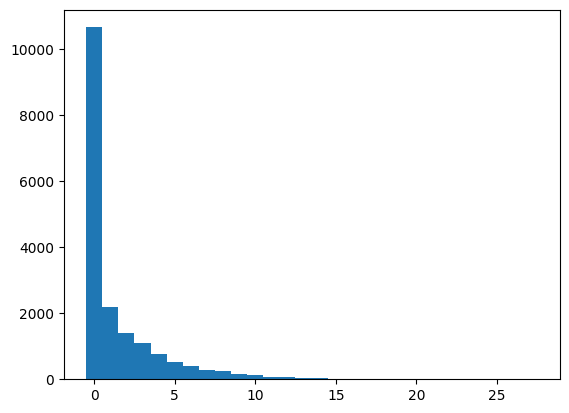

In [49]:
x, _ = preemptMonitor.xt()
print(np.array(x))

from matplotlib import pyplot as plt
bins = np.arange(max(x)+1)-0.5
plt.hist(x, bins)
plt.show()

The following code plots a histogram of the total system time of priority-1 requests.
Although the service time is defined to have an exponential distribution, it is clear
that the total system time does not.

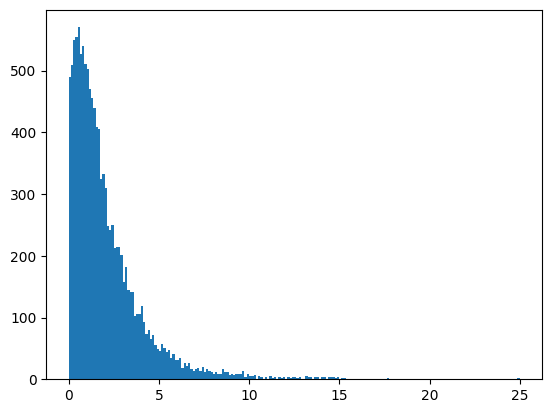

In [50]:
x, _ = sys_time[1].xt()
plt.hist(x, 200)
plt.show()

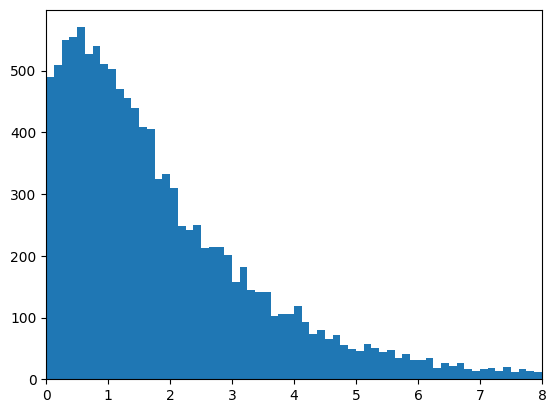

In [55]:
plt.hist(x, 200)
plt.xlim((0,8))
plt.show()